## 1. 데이터 준비

### 1-1. 모듈 임포트

In [316]:
import pandas as pd
import numpy as np
import requests
import asyncio
import aiohttp
import nest_asyncio
import logging
from aiolimiter import AsyncLimiter
import re
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [336]:
plt.rc('font', family='Noto Sans KR')
plt.rcParams['axes.unicode_minus'] = False

### 1-2. 데이터 로드

- '광진구 음식점 인허가 정보' 데이터 로드
- 컬럼명 한글화 적용

In [50]:
df = pd.read_csv('광진구 음식점 인허가 정보.csv', index_col=0)

C:\Users\louis\AppData\Local\Temp\ipykernel_12360\2885624363.py:1: DtypeWarning: Columns (37,42,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('광진구 음식점 인허가 정보.csv', index_col=0)


In [51]:
df

,OPNSFTEAMCODE,MGTNO,APVPERMYMD,APVCANCELYMD,TRDSTATEGBN,TRDSTATENM,DTLSTATEGBN,DTLSTATENM,DCBYMD,CLGSTDT,...,FCTYSILJOBEPCNT,FCTYPDTJOBEPCNT,BDNGOWNSENM,ISREAM,MONAM,MULTUSNUPSOYN,FACILTOTSCP,JTUPSOASGNNO,JTUPSOMAINEDF,HOMEPAGE
0,3000000,3000000-101-1997-07612,1997-09-25,NaN,3,폐업,2,폐업,2003-06-18,NaN,...,NaN,NaN,NaN,NaN,NaN,N,10.50,NaN,NaN,NaN
1,3000000,3000000-101-1997-07610,1997-09-25,NaN,3,폐업,2,폐업,1999-02-26,NaN,...,NaN,NaN,NaN,NaN,NaN,N,40.60,NaN,NaN,NaN
2,3000000,3000000-101-2000-11659,2000-11-28,NaN,3,폐업,2,폐업,2004-03-09,NaN,...,NaN,NaN,NaN,NaN,NaN,N,23.40,NaN,NaN,NaN
3,3000000,3000000-101-2000-11660,2000-11-28,NaN,3,폐업,2,폐업,2004-05-27,NaN,...,NaN,NaN,NaN,NaN,NaN,N,15.97,NaN,NaN,NaN
4,3000000,3000000-101-1981-00796,1981-08-26,NaN,3,폐업,2,폐업,2003-05-09,NaN,...,NaN,NaN,NaN,NaN,NaN,N,211.44,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517075,3180000,3180000-101-2025-00181,2025-03-17,NaN,1,영업/정상,1,영업,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
517076,3180000,3180000-101-2025-00182,2025-03-17,NaN,1,영업/정상,1,영업,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
517077,3180000,3180000-101-2025-00183,2025-03-17,NaN,1,영업/정상,1,영업,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
517078,3000000,3000000-101-2025-00058,2025-03-17,NaN,1,영업/정상,1,영업,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
column_rename_dict = {
    'OPNSFTEAMCODE': '개방자치단체코드',
    'MGTNO': '관리번호',
#     'APVPERMYMD': '인허가일자',
    'APVCANCELYMD': '인허가취소일자',
    'TRDSTATEGBN': '영업상태코드',
    'TRDSTATENM': '영업상태명',
    'DTLSTATEGBN': '상세영업상태코드',
    'DTLSTATENM': '상세영업상태명',
#     'DCBYMD': '폐업일자',
    'CLGSTDT': '휴업시작일자',
    'CLGENDDT': '휴업종료일자',
    'ROPNYMD': '재개업일자',
    'SITETEL': '전화번호',
    'SITEAREA': '소재지면적',
    'SITEPOSTNO': '소재지우편번호',
    'SITEWHLADDR': '지번주소',
    'RDNWHLADDR': '도로명주소',
    'RDNPOSTNO': '도로명우편번호',
    'BPLCNM': '사업장명',
    'LASTMODTS': '최종수정일자',
    'UPDATEGBN': '데이터갱신구분',
    'UPDATEDT': '데이터갱신일자',
    'UPTAENM': '업태구분명',
    'X': '좌표정보(X)',
    'Y': '좌표정보(Y)',
    'SNTUPTAENM': '위생업태명',
    'MANEIPCNT': '남성종사자수',
    'WMEIPCNT': '여성종사자수',
    'TRDPJUBNSENM': '영업장주변구분명',
    'LVSENM': '등급구분명',
    'WTRSPLYFACILSENM': '급수시설구분명',
    'TOTEPNUM': '총인원',
    'HOFFEPCNT': '본사종업원수',
    'FCTYOWKEPCNT': '공장사무직종업원수',
    'FCTYSILJOBEPCNT': '공장생산직종업원수',
    'FCTYPDTJOBEPCNT': '공장판매직종업원수',
    'BDNGOWNSENM': '건물소유구분명',
    'ISREAM': '보증액',
    'MONAM': '월세액',
    'MULTUSNUPSOYN': '다중이용업소여부',
    'FACILTOTSCP': '시설총규모',
    'JTUPSOASGNNO': '전통업소지정번호',
    'JTUPSOMAINEDF': '전통업소주된음식',
    'HOMEPAGE': '홈페이지'
}

### 1-3. 데이터 필터링

- 도로명주소 또는 지번주소에 **광진구**가 포함된 데이터만을 추출해야 함.
- 아직 **영업 중**이거나, **2024년에 폐업**한 데이터만을 추출해야 함.

In [37]:
restaurant_df = df[(df['SITEWHLADDR'].str.contains('광진구'))|(df['RDNWHLADDR'].str.contains('광진구'))]\
    .rename(columns=column_rename_dict)

restaurant_df['인허가일자'] = pd.to_datetime(restaurant_df['APVPERMYMD'])
restaurant_df['폐업일자'] = pd.to_datetime(restaurant_df['DCBYMD'])

restaurant_df

,개방자치단체코드,관리번호,APVPERMYMD,인허가취소일자,영업상태코드,영업상태명,상세영업상태코드,상세영업상태명,DCBYMD,휴업시작일자,...,건물소유구분명,보증액,월세액,다중이용업소여부,시설총규모,전통업소지정번호,전통업소주된음식,홈페이지,인허가일자,폐업일자
1502,3040000,3040000-101-2000-08815,2000-01-10,NaN,3,폐업,2,폐업,2005-10-06,NaN,...,NaN,NaN,NaN,N,24.90,NaN,NaN,NaN,2000-01-10,2005-10-06
1503,3040000,3040000-101-2000-08812,2000-01-10,NaN,3,폐업,2,폐업,2009-11-24,NaN,...,NaN,NaN,NaN,N,16.50,NaN,NaN,NaN,2000-01-10,2009-11-24
1504,3040000,3040000-101-2008-00031,2008-02-11,NaN,3,폐업,2,폐업,2020-06-29,NaN,...,NaN,NaN,NaN,N,66.00,NaN,NaN,NaN,2008-02-11,2020-06-29
1505,3040000,3040000-101-2008-00032,2008-02-11,NaN,3,폐업,2,폐업,2010-05-24,NaN,...,NaN,NaN,NaN,N,78.28,NaN,NaN,NaN,2008-02-11,2010-05-24
1506,3040000,3040000-101-2006-00282,2006-11-28,NaN,3,폐업,2,폐업,2007-12-26,NaN,...,NaN,NaN,NaN,N,0.00,NaN,NaN,NaN,2006-11-28,2007-12-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516865,3040000,3040000-101-2015-00208,2015-07-28,NaN,1,영업/정상,1,영업,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-07-28,NaT
516949,3040000,3040000-101-2020-00406,2020-11-11,NaN,1,영업/정상,1,영업,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-11,NaT
516950,3040000,3040000-101-2020-00303,2020-08-20,NaN,1,영업/정상,1,영업,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-20,NaT
516966,3040000,3040000-101-2016-00157,2016-06-02,NaN,1,영업/정상,1,영업,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-06-02,NaT


In [299]:
gwangjin_df = restaurant_df[(restaurant_df['폐업일자'].isna()) | (restaurant_df['폐업일자'].dt.year >= 2024)][[
    '사업장명', '상세영업상태명', '인허가일자', '폐업일자', '지번주소', '도로명주소', '업태구분명', '좌표정보(X)', '좌표정보(Y)'
]]
gwangjin_df

,사업장명,상세영업상태명,인허가일자,폐업일자,지번주소,도로명주소,업태구분명,좌표정보(X),좌표정보(Y)
53174,도선,폐업,2006-03-29,2024-01-30,서울특별시 광진구 구의동 546-1 지하1층,"서울특별시 광진구 강변역로 50 (구의동,지하1층)",중국식,208201.993321,447967.299542
71680,주식회사 대신에프앤,폐업,2024-12-17,2025-01-02,서울특별시 광진구 자양동 227-342 롯데백화점,"서울특별시 광진구 능동로 92, 롯데백화점 지하1층 (자양동)",한식,206217.434726,448506.218744
71681,도로시파스타연정 건대점,폐업,2023-11-20,2024-12-20,서울특별시 광진구 군자동 503 광진두산위브파크,"서울특별시 광진구 광나루로 369, 지하1층 B114호 (군자동, 광진두산위브파크)",경양식,206212.244268,449577.174891
71682,꼴까닭 치킨,폐업,2023-10-11,2024-11-12,서울특별시 광진구 자양동 770-33,"서울특별시 광진구 자양로19길 44, 1층 (자양동)",호프/통닭,207089.400601,448445.547891
71683,쥬만지,폐업,2023-11-02,2024-11-12,서울특별시 광진구 자양동 630-37 2층,"서울특별시 광진구 뚝섬로57길 58, 2층 (자양동)",한식,207203.983181,447991.261133
...,...,...,...,...,...,...,...,...,...
516865,본능족으로 족발보쌈,영업,2015-07-28,NaT,서울특별시 광진구 군자동 471-1,서울특별시 광진구 능동로35길 41 (군자동),한식,206715.163963,450559.947859
516949,키라키라윤 군자점,영업,2020-11-11,NaT,서울특별시 광진구 중곡동 158-24 103호,"서울특별시 광진구 능동로 320, 1층 103호 (중곡동)",일식,207024.642620,450656.038395
516950,로꼬브리또 자양점,영업,2020-08-20,NaT,서울특별시 광진구 자양동 623-19 1층,"서울특별시 광진구 자양로13길 60, 1층 (자양동)","외국음식전문점(인도,태국등)",207116.673802,447977.731235
516966,별이빛나는밤에,영업,2016-06-02,NaT,서울특별시 광진구 중곡동 93-46 지하1층,"서울특별시 광진구 용마산로 8, 지층 (중곡동)",라이브카페,207771.329956,450223.753610


In [93]:
gwangjin_df.isna().sum()

사업장명          0
상세영업상태명       0
인허가일자         0
폐업일자       4268
지번주소          0
도로명주소         8
업태구분명         0
좌표정보(X)      21
좌표정보(Y)      21
행정동        2666
dtype: int64

### 1-4. 행정동 매핑 (카카오맵 API)

- 지번주소는 법정동 기준으로 되어 있으므로, 올바른 분석을 위해 해당 장소의 **행정동**을 매핑해야 함.
- 이를 위해 **카카오맵 REST API**의 두 가지 엔드포인트를 활용함.
    - 먼저 '좌표를 행정구역 정보로 변환하기'를 활용함. [\[docs 링크\]](https://developers.kakao.com/docs/latest/ko/local/dev-guide#coord-to-district)
    - 수집 불가능한(좌표정보가 비어있는) 데이터는 '주소를 좌표로 변환하기'를 활용함. [\[docs 링크\]](https://developers.kakao.com/docs/latest/ko/local/dev-guide#address-coord)

#### 1-4-1. 좌표-행정동 매핑

In [100]:
# Jupyter Notebook 환경에서 asyncio.run() 허용
nest_asyncio.apply()

# 로깅 설정
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s %(message)s',
    datefmt='%H:%M:%S'
)
logger = logging.getLogger(__name__)

# 상수 정의
KEY = '923dc9604178f2a7aa0979ae38029a34'
URL = 'https://dapi.kakao.com/v2/local/geo/coord2regioncode.json'
HEADERS = {"Authorization": f"KakaoAK {KEY}"}

RATE_LIMIT = 200     # 초당 허용 요청 수
BATCH_SIZE = RATE_LIMIT
INTERVAL = 1         # 배치 사이 대기 시간 (초)
MAX_RETRIES = 5      # 재시도 최대 횟수
BACKOFF_BASE = 0.5   # 백오프 베이스 시간 (초)

# AsyncLimiter 인스턴스 생성 (초당 RATE_LIMIT 건)
limiter = AsyncLimiter(RATE_LIMIT, time_period=1)

# 단일 요청 비동기 함수 (429 재시도 & 스로틀링)
async def fetch_region(session, idx, x, y):
    params = {'x': x, 'y': y, 'input_coord': 'TM'}
    for attempt in range(1, MAX_RETRIES + 1):
        async with limiter:
            try:
                async with session.get(URL, params=params, headers=HEADERS) as resp:
                    status = resp.status
                    text = await resp.text()
                    if status == 200:
                        data = await resp.json()
                        for doc in data.get('documents', []):
                            if doc.get('region_type') == 'H':
                                return True, idx, doc.get('region_3depth_name')
                        return False, idx, None
                    elif status == 429:
                        retry_after = resp.headers.get('Retry-After')
                        wait = float(retry_after) if retry_after else BACKOFF_BASE * 2**(attempt-1)
                        logger.warning(f"429 for idx={idx}, retry_after={wait:.2f}s (attempt {attempt})")
                        await asyncio.sleep(wait)
                        continue
                    else:
                        logger.error(f"HTTP {status} for idx={idx}: {text[:200]}")
                        return False, idx, None
            except Exception as e:
                logger.error(f"Exception for idx={idx} on attempt {attempt}: {e}")
                await asyncio.sleep(BACKOFF_BASE * 2**(attempt-1))
                continue
    logger.error(f"Max retries exceeded for idx={idx}")
    return False, idx, None

# 메인 비동기 루틴 (NaN 체크 추가)
async def main():
    results = {}
    invalid_coords = []   # NaN 좌표 보관용
    total_calls = 0
    success_calls = 0

    async with aiohttp.ClientSession() as session:
        for start in range(0, len(gwangjin_df), BATCH_SIZE):
            batch = gwangjin_df.iloc[start:start + BATCH_SIZE]

            tasks = []
            for idx, row in batch.iterrows():
                x, y = row['좌표정보(X)'], row['좌표정보(Y)']
                if pd.isna(x) or pd.isna(y):
                    invalid_coords.append(idx)
                else:
                    tasks.append(fetch_region(session, idx, x, y))

            if tasks:
                responses = await asyncio.gather(*tasks)
                for ok, idx, region_name in responses:
                    total_calls += 1
                    if ok:
                        results[idx] = region_name
                        success_calls += 1

                success_rate = (success_calls / total_calls) * 100 if total_calls else 0
                logger.info(f"[Batch {start//BATCH_SIZE+1}] 총 호출: {total_calls}회, "
                            f"성공: {success_calls}회, 성공률: {success_rate:.2f}%")
            else:
                logger.info(f"[Batch {start//BATCH_SIZE+1}] 유효 좌표 없음, API 호출 생략")

            await asyncio.sleep(INTERVAL)

    # 결과와 NaN 좌표 인덱스 리스트 함께 반환
    return results, invalid_coords

In [101]:
final_results, invalid_coords = asyncio.run(main())
print(f"\n최종 저장된 결과 개수: {len(final_results)}개")

17:36:38 INFO [Batch 1] 총 호출: 198회, 성공: 198회, 성공률: 100.00%
17:36:40 INFO [Batch 2] 총 호출: 395회, 성공: 395회, 성공률: 100.00%
17:36:41 INFO [Batch 3] 총 호출: 594회, 성공: 594회, 성공률: 100.00%
17:36:42 INFO [Batch 4] 총 호출: 792회, 성공: 792회, 성공률: 100.00%
17:36:43 INFO [Batch 5] 총 호출: 992회, 성공: 992회, 성공률: 100.00%
17:36:44 INFO [Batch 6] 총 호출: 1192회, 성공: 1192회, 성공률: 100.00%
17:36:46 INFO [Batch 7] 총 호출: 1392회, 성공: 1392회, 성공률: 100.00%
17:36:47 INFO [Batch 8] 총 호출: 1591회, 성공: 1591회, 성공률: 100.00%
17:36:48 INFO [Batch 9] 총 호출: 1790회, 성공: 1790회, 성공률: 100.00%
17:36:49 INFO [Batch 10] 총 호출: 1990회, 성공: 1990회, 성공률: 100.00%
17:36:50 INFO [Batch 11] 총 호출: 2190회, 성공: 2190회, 성공률: 100.00%
17:36:51 INFO [Batch 12] 총 호출: 2390회, 성공: 2390회, 성공률: 100.00%
17:36:52 INFO [Batch 13] 총 호출: 2590회, 성공: 2590회, 성공률: 100.00%
17:36:54 INFO [Batch 14] 총 호출: 2790회, 성공: 2790회, 성공률: 100.00%
17:36:55 INFO [Batch 15] 총 호출: 2990회, 성공: 2990회, 성공률: 100.00%
17:36:56 INFO [Batch 16] 총 호출: 3189회, 성공: 3189회, 성공률: 100.00%
17:36:57 INFO [Batch 17] 총 


✅ 최종 저장된 결과 개수: 4745개


#### 1-4-2. 지번주소-행정동 매핑

In [142]:
key = '923dc9604178f2a7aa0979ae38029a34'
url = 'https://dapi.kakao.com/v2/local/search/address.json'
headers = {"Authorization": f"KakaoAK {KEY}"}

address_results = {}
error_coords = []

In [143]:
for idx, row in gwangjin_df.loc[invalid_coords].iterrows():
    params = {'query': row['지번주소'], 'page': 1} 
    response = requests.get(url, params=params, headers=headers).json()
    
    if response['meta']['total_count'] > 0:
        address_results[idx] = response['documents'][0]['address']['region_3depth_h_name']
        
    else:
        error_coords.append(idx)

#### 1-4-3. 결측치 수작업 수집

In [168]:
print(f"수집 완료: {len(final_results | address_results)} / {len(gwangjin_df)} \
({np.round(100 * len(final_results | address_results) / len(gwangjin_df), 2)}%)")
print(f"미수집: {len(gwangjin_df) - len(final_results | address_results)}")

수집 완료: 4757 / 4766 (99.81%)
미수집: 9


- 여전히 9개 행의 행정동이 수집 안 된 상태임.

In [172]:
gwangjin_df.loc[error_coords]

,사업장명,상세영업상태명,인허가일자,폐업일자,지번주소,도로명주소,업태구분명,좌표정보(X),좌표정보(Y)
72020,힐사이드,폐업,2015-05-21,2024-02-08,서울특별시 광진구 자양동 2-53 지층 1호,"서울특별시 광진구 능동로 77, 지층 1호 (자양동)",호프/통닭,NaN,NaN
73085,만남호프,폐업,2002-06-05,2024-07-12,서울특별시 광진구 자양동 2-30,서울특별시 광진구 아차산로34길 29 (자양동),호프/통닭,NaN,NaN
75725,둘리치킨,폐업,1999-03-22,2024-07-12,서울특별시 광진구 자양동 115-9 (A동),NaN,호프/통닭,NaN,NaN
78982,마차호프,폐업,1994-08-31,2024-07-12,서울특별시 광진구 자양동 3-5,서울특별시 광진구 동일로18길 122 (자양동),호프/통닭,NaN,NaN
81592,허씨네통닭,폐업,2000-02-19,2024-07-12,서울특별시 광진구 자양동 469-101,NaN,통닭(치킨),NaN,NaN
85876,수채화,영업,2006-02-09,NaT,서울특별시 광진구 중곡동 56-17번지,서울특별시 광진구 긴고랑로 103-1 (중곡동),까페,NaN,NaN
87470,다이스호프,영업,1997-06-05,NaT,서울특별시 광진구 자양동 552-2번지,NaN,호프/통닭,NaN,NaN
87832,갯벌낙지,영업,2009-03-26,NaT,서울특별시 광진구 화양동 111-93번지,서울특별시 광진구 능동로 174 (화양동),한식,NaN,NaN
88437,명랑식당,영업,1987-06-20,NaT,서울특별시 광진구 중곡동 340-4번지,NaN,한식,NaN,NaN


In [151]:
diy_results = {
    72020: '자양4동',
    73085: '자양4동',
    75725: '자양3동',
    78982: '자양4동',
    81592: np.nan,
    85876: '중곡2동',
    87470: '자양4동',
    87832: '화양동',
    88437: '중곡2동'
}

- 네이버 지도에 검색하여 수작업으로 행정동 수집 진행함.
- '허씨네통닭(81592)'의 경우 네이버 지도에도 안 나와서 결측치 처리함.

In [173]:
ffinal_results = final_results | address_results | diy_results
gwangjin_df['행정동'] = ffinal_results
gwangjin_df

,사업장명,상세영업상태명,인허가일자,폐업일자,지번주소,도로명주소,업태구분명,좌표정보(X),좌표정보(Y),행정동
53174,도선,폐업,2006-03-29,2024-01-30,서울특별시 광진구 구의동 546-1 지하1층,"서울특별시 광진구 강변역로 50 (구의동,지하1층)",중국식,208201.993321,447967.299542,구의3동
71681,도로시파스타연정 건대점,폐업,2023-11-20,2024-12-20,서울특별시 광진구 군자동 503 광진두산위브파크,"서울특별시 광진구 광나루로 369, 지하1층 B114호 (군자동, 광진두산위브파크)",경양식,206212.244268,449577.174891,군자동
71682,꼴까닭 치킨,폐업,2023-10-11,2024-11-12,서울특별시 광진구 자양동 770-33,"서울특별시 광진구 자양로19길 44, 1층 (자양동)",호프/통닭,207089.400601,448445.547891,자양1동
71683,쥬만지,폐업,2023-11-02,2024-11-12,서울특별시 광진구 자양동 630-37 2층,"서울특별시 광진구 뚝섬로57길 58, 2층 (자양동)",한식,207203.983181,447991.261133,자양1동
71684,커피홍당무,폐업,2023-10-24,2024-10-04,서울특별시 광진구 중곡동 56-16 1층,"서울특별시 광진구 긴고랑로31길 5, 1층 (중곡동)",기타,207620.648296,450861.799810,중곡2동
...,...,...,...,...,...,...,...,...,...,...
516865,본능족으로 족발보쌈,영업,2015-07-28,NaT,서울특별시 광진구 군자동 471-1,서울특별시 광진구 능동로35길 41 (군자동),한식,206715.163963,450559.947859,군자동
516949,키라키라윤 군자점,영업,2020-11-11,NaT,서울특별시 광진구 중곡동 158-24 103호,"서울특별시 광진구 능동로 320, 1층 103호 (중곡동)",일식,207024.642620,450656.038395,중곡2동
516950,로꼬브리또 자양점,영업,2020-08-20,NaT,서울특별시 광진구 자양동 623-19 1층,"서울특별시 광진구 자양로13길 60, 1층 (자양동)","외국음식전문점(인도,태국등)",207116.673802,447977.731235,자양1동
516966,별이빛나는밤에,영업,2016-06-02,NaT,서울특별시 광진구 중곡동 93-46 지하1층,"서울특별시 광진구 용마산로 8, 지층 (중곡동)",라이브카페,207771.329956,450223.753610,중곡4동


#### 1-4-4. 법정동-행정동 비교

- 행정동이 올바르게 수집되었는지 파악하기 위해 기존 데이터의 '지번주소'와 비교함.

In [175]:
gwangjin_df['법정동'] = gwangjin_df['지번주소'].str.split().str[2]

gwangjin_df.head()

,사업장명,상세영업상태명,인허가일자,폐업일자,지번주소,도로명주소,업태구분명,좌표정보(X),좌표정보(Y),행정동,법정동
53174,도선,폐업,2006-03-29,2024-01-30,서울특별시 광진구 구의동 546-1 지하1층,"서울특별시 광진구 강변역로 50 (구의동,지하1층)",중국식,208201.993321,447967.299542,구의3동,구의동
71681,도로시파스타연정 건대점,폐업,2023-11-20,2024-12-20,서울특별시 광진구 군자동 503 광진두산위브파크,"서울특별시 광진구 광나루로 369, 지하1층 B114호 (군자동, 광진두산위브파크)",경양식,206212.244268,449577.174891,군자동,군자동
71682,꼴까닭 치킨,폐업,2023-10-11,2024-11-12,서울특별시 광진구 자양동 770-33,"서울특별시 광진구 자양로19길 44, 1층 (자양동)",호프/통닭,207089.400601,448445.547891,자양1동,자양동
71683,쥬만지,폐업,2023-11-02,2024-11-12,서울특별시 광진구 자양동 630-37 2층,"서울특별시 광진구 뚝섬로57길 58, 2층 (자양동)",한식,207203.983181,447991.261133,자양1동,자양동
71684,커피홍당무,폐업,2023-10-24,2024-10-04,서울특별시 광진구 중곡동 56-16 1층,"서울특별시 광진구 긴고랑로31길 5, 1층 (중곡동)",기타,207620.648296,450861.799810,중곡2동,중곡동


In [176]:
def is_mapping_ok(adm, legal):
    try:
        if adm == legal:
            return True
        m = re.match(r'^(.+?)(\d+)동$', adm)
        if m:
            prefix = m.group(1)
            return (prefix + '동') == legal
    except:
        return False

gwangjin_df['일치여부'] = gwangjin_df.apply(lambda row: is_mapping_ok(row['행정동'], row['법정동']), axis=1)

gwangjin_df[['행정동', '법정동', '일치여부']].head(10)

,행정동,법정동,일치여부
53174,구의3동,구의동,True
71681,군자동,군자동,True
71682,자양1동,자양동,True
71683,자양1동,자양동,True
71684,중곡2동,중곡동,True
71685,군자동,군자동,True
71686,군자동,군자동,True
71688,자양4동,자양동,True
71689,중곡1동,중곡동,True
71690,군자동,군자동,True


In [179]:
gwangjin_df[gwangjin_df['일치여부'] == False]

,사업장명,상세영업상태명,인허가일자,폐업일자,지번주소,도로명주소,업태구분명,좌표정보(X),좌표정보(Y),행정동,법정동,일치여부
81592,허씨네통닭,폐업,2000-02-19,2024-07-12,서울특별시 광진구 자양동 469-101,NaN,통닭(치킨),NaN,NaN,NaN,자양동,False
85305,진퉁감자탕해장국,영업,2010-04-13,NaT,서울특별시 광진구 구의동 50-13 1층,"서울특별시 광진구 자양로 287, 1층 (구의동)",한식,205862.000102,448736.640335,자양4동,구의동,False


- 허씨네통닭: drop
- 진퉁감자탕해장국: 얼토당토 않은 위치인 것으로 보아 이사를 한 게 아닐까 싶음. 수작업으로 수정

In [181]:
gwangjin_df.loc[85305, '행정동'] = '구의2동'

In [264]:
gwangjin_df_dropped = gwangjin_df.drop(81592)
gwangjin_df_dropped

,사업장명,상세영업상태명,인허가일자,폐업일자,지번주소,도로명주소,업태구분명,좌표정보(X),좌표정보(Y),행정동,법정동,일치여부
53174,도선,폐업,2006-03-29,2024-01-30,서울특별시 광진구 구의동 546-1 지하1층,"서울특별시 광진구 강변역로 50 (구의동,지하1층)",중국식,208201.993321,447967.299542,구의3동,구의동,True
71681,도로시파스타연정 건대점,폐업,2023-11-20,2024-12-20,서울특별시 광진구 군자동 503 광진두산위브파크,"서울특별시 광진구 광나루로 369, 지하1층 B114호 (군자동, 광진두산위브파크)",경양식,206212.244268,449577.174891,군자동,군자동,True
71682,꼴까닭 치킨,폐업,2023-10-11,2024-11-12,서울특별시 광진구 자양동 770-33,"서울특별시 광진구 자양로19길 44, 1층 (자양동)",호프/통닭,207089.400601,448445.547891,자양1동,자양동,True
71683,쥬만지,폐업,2023-11-02,2024-11-12,서울특별시 광진구 자양동 630-37 2층,"서울특별시 광진구 뚝섬로57길 58, 2층 (자양동)",한식,207203.983181,447991.261133,자양1동,자양동,True
71684,커피홍당무,폐업,2023-10-24,2024-10-04,서울특별시 광진구 중곡동 56-16 1층,"서울특별시 광진구 긴고랑로31길 5, 1층 (중곡동)",기타,207620.648296,450861.799810,중곡2동,중곡동,True
...,...,...,...,...,...,...,...,...,...,...,...,...
516865,본능족으로 족발보쌈,영업,2015-07-28,NaT,서울특별시 광진구 군자동 471-1,서울특별시 광진구 능동로35길 41 (군자동),한식,206715.163963,450559.947859,군자동,군자동,True
516949,키라키라윤 군자점,영업,2020-11-11,NaT,서울특별시 광진구 중곡동 158-24 103호,"서울특별시 광진구 능동로 320, 1층 103호 (중곡동)",일식,207024.642620,450656.038395,중곡2동,중곡동,True
516950,로꼬브리또 자양점,영업,2020-08-20,NaT,서울특별시 광진구 자양동 623-19 1층,"서울특별시 광진구 자양로13길 60, 1층 (자양동)","외국음식전문점(인도,태국등)",207116.673802,447977.731235,자양1동,자양동,True
516966,별이빛나는밤에,영업,2016-06-02,NaT,서울특별시 광진구 중곡동 93-46 지하1층,"서울특별시 광진구 용마산로 8, 지층 (중곡동)",라이브카페,207771.329956,450223.753610,중곡4동,중곡동,True


### 1-5. 영업 기간 계산

In [262]:
gwangjin_df_dropped[(gwangjin_df_dropped['상세영업상태명'] == '폐업') & gwangjin_df_dropped['폐업일자'].isna()]

,사업장명,상세영업상태명,인허가일자,폐업일자,지번주소,도로명주소,업태구분명,좌표정보(X),좌표정보(Y),행정동,법정동,일치여부
78593,새미야식,폐업,2000-05-09,NaT,서울특별시 광진구 화양동 33-43번지,NaN,분식,206045.559056,449149.538587,화양동,화양동,True


- 폐업되었으나 폐업일자가 없는 데이터가 있어서 제거해야 함.

In [265]:
gwangjin_df_dropped = gwangjin_df_dropped.drop(78593)

In [275]:
# 폐업된 경우
gwangjin_df_dropped['영업기간'] = gwangjin_df_dropped['폐업일자'] - gwangjin_df_dropped['인허가일자']

# 영업 중인 경우
gwangjin_df_dropped.loc[df['상세영업상태명'] == '영업', '영업기간'] = (
    datetime.datetime.today() - pd.to_datetime(gwangjin_df_dropped.loc[df['상세영업상태명'] == '영업', '인허가일자'])
)

gwangjin_df_dropped['영업기간(일)'] = gwangjin_df_dropped['영업기간'].dt.days

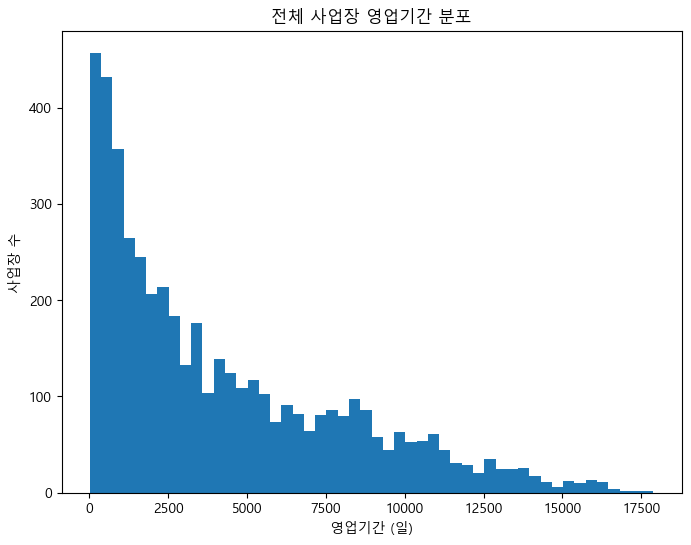

In [278]:
plt.figure(figsize=(8, 6))
plt.hist(gwangjin_df_dropped['영업기간(일)'], bins=50)
plt.title('전체 사업장 영업기간 분포')
plt.xlabel('영업기간 (일)')
plt.ylabel('사업장 수')
plt.show()

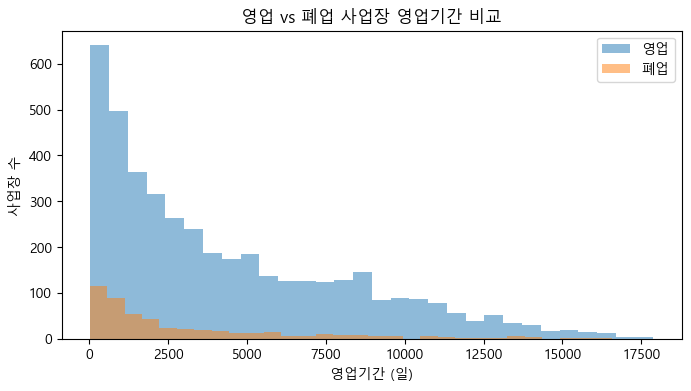

In [280]:
plt.figure(figsize=(8,4))
for status in ['영업','폐업']:
    subset = gwangjin_df_dropped[gwangjin_df_dropped['상세영업상태명']==status]['영업기간(일)']
    plt.hist(subset, bins=30, alpha=0.5, label=status)
plt.legend()
plt.title('영업 vs 폐업 사업장 영업기간 비교')
plt.xlabel('영업기간 (일)')
plt.ylabel('사업장 수')
plt.show()

---

## 2. 폐업 기준 분류

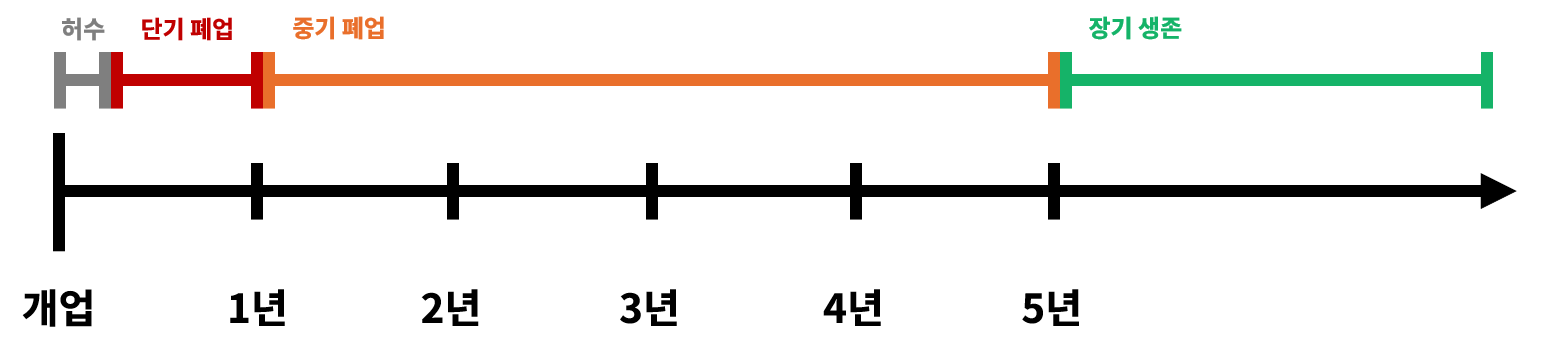

In [285]:
gwangjin_df_dropped['영업기간분류'] = gwangjin_df_dropped['영업기간'].apply(
    lambda x: "허수" if x <= datetime.timedelta(90)
    else "단기 폐업" if x <= datetime.timedelta(365)
    else "중기 폐업" if x <= datetime.timedelta(365 * 5)
    else "장기 생존"
)

In [286]:
gwangjin_df_dropped

,사업장명,상세영업상태명,인허가일자,폐업일자,지번주소,도로명주소,업태구분명,좌표정보(X),좌표정보(Y),행정동,법정동,일치여부,영업기간(일),영업기간,영업기간분류
53174,도선,폐업,2006-03-29,2024-01-30,서울특별시 광진구 구의동 546-1 지하1층,"서울특별시 광진구 강변역로 50 (구의동,지하1층)",중국식,208201.993321,447967.299542,구의3동,구의동,True,6516,6516 days 00:00:00,장기 생존
71681,도로시파스타연정 건대점,폐업,2023-11-20,2024-12-20,서울특별시 광진구 군자동 503 광진두산위브파크,"서울특별시 광진구 광나루로 369, 지하1층 B114호 (군자동, 광진두산위브파크)",경양식,206212.244268,449577.174891,군자동,군자동,True,396,396 days 00:00:00,중기 폐업
71682,꼴까닭 치킨,폐업,2023-10-11,2024-11-12,서울특별시 광진구 자양동 770-33,"서울특별시 광진구 자양로19길 44, 1층 (자양동)",호프/통닭,207089.400601,448445.547891,자양1동,자양동,True,398,398 days 00:00:00,중기 폐업
71683,쥬만지,폐업,2023-11-02,2024-11-12,서울특별시 광진구 자양동 630-37 2층,"서울특별시 광진구 뚝섬로57길 58, 2층 (자양동)",한식,207203.983181,447991.261133,자양1동,자양동,True,376,376 days 00:00:00,중기 폐업
71684,커피홍당무,폐업,2023-10-24,2024-10-04,서울특별시 광진구 중곡동 56-16 1층,"서울특별시 광진구 긴고랑로31길 5, 1층 (중곡동)",기타,207620.648296,450861.799810,중곡2동,중곡동,True,346,346 days 00:00:00,단기 폐업
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516865,본능족으로 족발보쌈,영업,2015-07-28,NaT,서울특별시 광진구 군자동 471-1,서울특별시 광진구 능동로35길 41 (군자동),한식,206715.163963,450559.947859,군자동,군자동,True,3551,3551 days 18:47:00.049204,장기 생존
516949,키라키라윤 군자점,영업,2020-11-11,NaT,서울특별시 광진구 중곡동 158-24 103호,"서울특별시 광진구 능동로 320, 1층 103호 (중곡동)",일식,207024.642620,450656.038395,중곡2동,중곡동,True,1618,1618 days 18:47:00.049204,중기 폐업
516950,로꼬브리또 자양점,영업,2020-08-20,NaT,서울특별시 광진구 자양동 623-19 1층,"서울특별시 광진구 자양로13길 60, 1층 (자양동)","외국음식전문점(인도,태국등)",207116.673802,447977.731235,자양1동,자양동,True,1701,1701 days 18:47:00.049204,중기 폐업
516966,별이빛나는밤에,영업,2016-06-02,NaT,서울특별시 광진구 중곡동 93-46 지하1층,"서울특별시 광진구 용마산로 8, 지층 (중곡동)",라이브카페,207771.329956,450223.753610,중곡4동,중곡동,True,3241,3241 days 18:47:00.049204,장기 생존


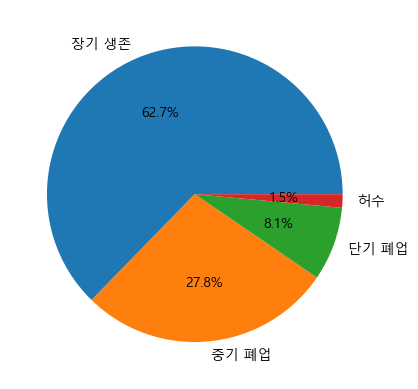

In [300]:
by_category = gwangjin_df_dropped['영업기간분류'].value_counts().to_frame()

plt.pie(
    by_category['영업기간분류'],
    labels=by_category.index,
    autopct='%.1f%%'
)

plt.show()

In [314]:
proportions = (
    gwangjin_df_dropped
    .groupby('행정동')['영업기간분류']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
) * 100

proportions = proportions[['장기 생존', '중기 폐업', '단기 폐업', '허수']]

proportions

영업기간분류,장기 생존,중기 폐업,단기 폐업,허수
행정동,,,,
광장동,68.108108,21.081081,9.729730,1.081081
구의1동,63.613861,29.455446,5.198020,1.732673
구의2동,60.975610,29.674797,7.317073,2.032520
구의3동,70.192308,21.474359,7.371795,0.961538
군자동,56.140351,29.573935,12.280702,2.005013
능동,62.500000,28.947368,7.894737,0.657895
자양1동,59.271523,31.125828,8.940397,0.662252
자양2동,68.072289,25.301205,6.024096,0.602410
자양3동,61.722488,23.923445,10.526316,3.827751


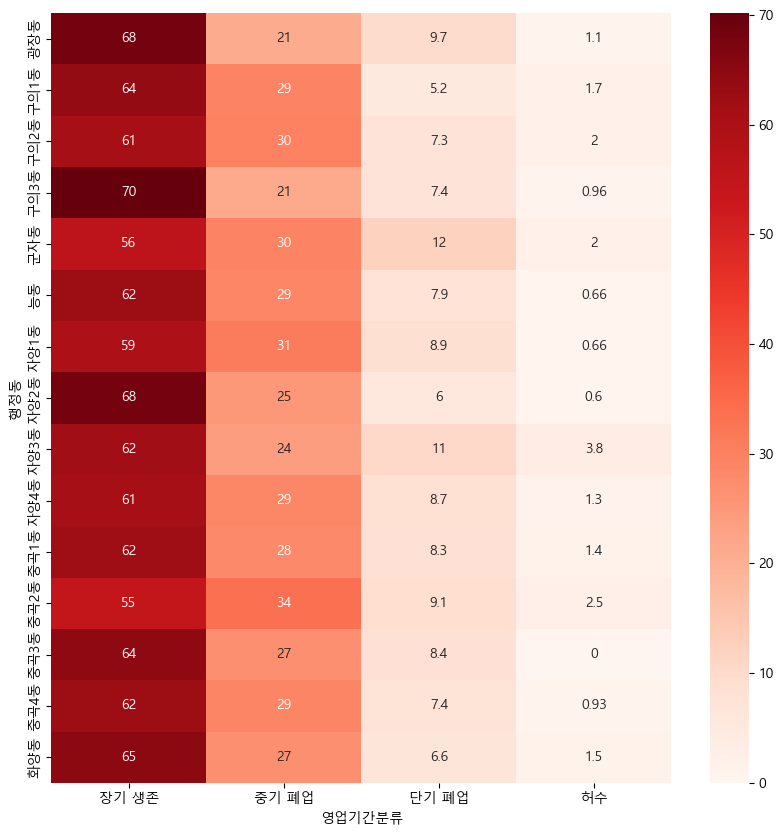

In [323]:
plt.figure(figsize=(10, 10))

sns.heatmap(
    proportions,
    cmap='Reds',
    annot=True
)

plt.show()

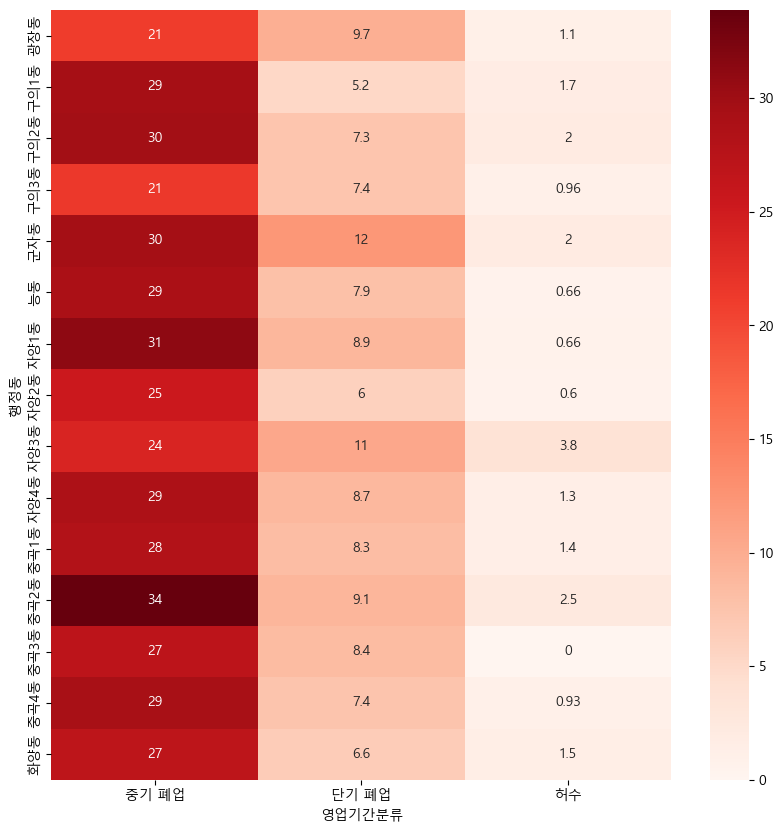

In [324]:
plt.figure(figsize=(10, 10))

sns.heatmap(
    proportions[['중기 폐업', '단기 폐업', '허수']],
    cmap='Reds',
    annot=True
)

plt.show()

---

## 3. 행정동별 Z-Score

In [328]:
df = proportions.reset_index()
df

영업기간분류,행정동,장기 생존,중기 폐업,단기 폐업,허수
0,광장동,68.108108,21.081081,9.729730,1.081081
1,구의1동,63.613861,29.455446,5.198020,1.732673
2,구의2동,60.975610,29.674797,7.317073,2.032520
3,구의3동,70.192308,21.474359,7.371795,0.961538
4,군자동,56.140351,29.573935,12.280702,2.005013
5,능동,62.500000,28.947368,7.894737,0.657895
6,자양1동,59.271523,31.125828,8.940397,0.662252
7,자양2동,68.072289,25.301205,6.024096,0.602410
8,자양3동,61.722488,23.923445,10.526316,3.827751
9,자양4동,61.210762,28.699552,8.744395,1.345291


### 3-1. 단기 모델

In [329]:
mu = df['단기 폐업'].mean()
sigma = df['단기 폐업'].std(ddof=1)

df['단기_zscore'] = (df['단기 폐업'] - mu) / sigma
df

영업기간분류,행정동,장기 생존,중기 폐업,단기 폐업,허수,단기_zscore
0,광장동,68.108108,21.081081,9.729730,1.081081,0.824253
1,구의1동,63.613861,29.455446,5.198020,1.732673,-1.718402
2,구의2동,60.975610,29.674797,7.317073,2.032520,-0.529442
3,구의3동,70.192308,21.474359,7.371795,0.961538,-0.498739
4,군자동,56.140351,29.573935,12.280702,2.005013,2.255553
5,능동,62.500000,28.947368,7.894737,0.657895,-0.205326
6,자양1동,59.271523,31.125828,8.940397,0.662252,0.381374
7,자양2동,68.072289,25.301205,6.024096,0.602410,-1.254906
8,자양3동,61.722488,23.923445,10.526316,3.827751,1.271202
9,자양4동,61.210762,28.699552,8.744395,1.345291,0.271400


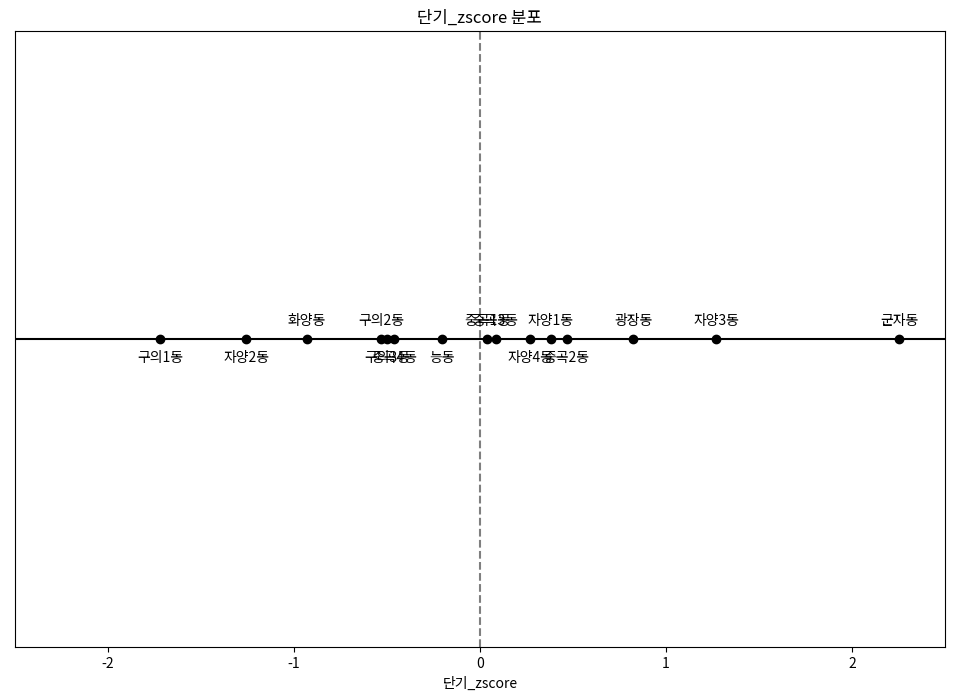

In [364]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.axhline(0, color='black')
ax.axvline(0, color='black', linestyle='--', alpha=0.5)
ax.scatter(df['단기_zscore'], [0] * len(df), marker='o', color='black')
ax.set_yticks([])
ax.set_xlabel('단기_zscore')
ax.set_xlim(-2.5, 2.5)
ax.set_title('단기_zscore 분포')

for idx, row in df.iterrows():
    offset = 0.002 if idx % 2 == 0 else -0.002
    va = 'bottom' if idx % 2 == 0 else 'top'
    ax.text(
        row['단기_zscore'],
        offset,
        row['행정동'],
        verticalalignment=va,
        horizontalalignment='center',
        fontsize=10
    )
    
plt.show()

### 3-2. 단기 + 중기 모델

In [330]:
df['폐업'] = df['단기 폐업'] + df['중기 폐업']
mu = df['폐업'].mean()
sigma = df['폐업'].std(ddof=1)

df['중단기_zscore'] = (df['폐업'] - mu) / sigma
df

영업기간분류,행정동,장기 생존,중기 폐업,단기 폐업,허수,단기_zscore,폐업,중단기_zscore
0,광장동,68.108108,21.081081,9.729730,1.081081,0.824253,30.810811,-1.300873
1,구의1동,63.613861,29.455446,5.198020,1.732673,-1.718402,34.653465,-0.318795
2,구의2동,60.975610,29.674797,7.317073,2.032520,-0.529442,36.991870,0.278837
3,구의3동,70.192308,21.474359,7.371795,0.961538,-0.498739,28.846154,-1.802986
4,군자동,56.140351,29.573935,12.280702,2.005013,2.255553,41.854637,1.521628
5,능동,62.500000,28.947368,7.894737,0.657895,-0.205326,36.842105,0.240562
6,자양1동,59.271523,31.125828,8.940397,0.662252,0.381374,40.066225,1.064559
7,자양2동,68.072289,25.301205,6.024096,0.602410,-1.254906,31.325301,-1.169383
8,자양3동,61.722488,23.923445,10.526316,3.827751,1.271202,34.449761,-0.370856
9,자양4동,61.210762,28.699552,8.744395,1.345291,0.271400,37.443946,0.394376


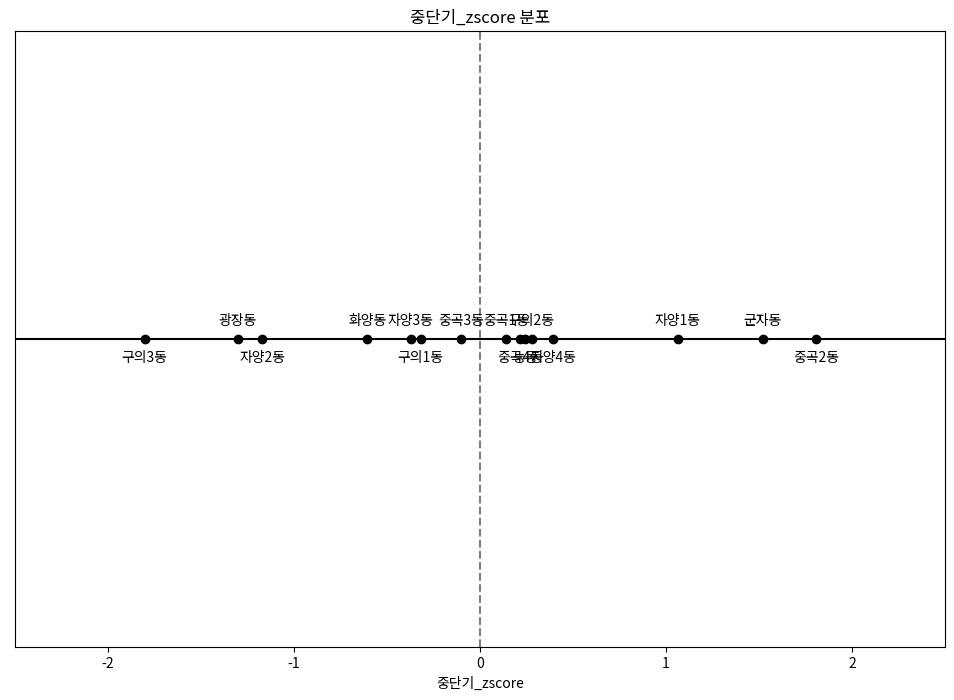

In [365]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.axhline(0, color='black')
ax.axvline(0, color='black', linestyle='--', alpha=0.5)
ax.scatter(df['중단기_zscore'], [0] * len(df), marker='o', color='black')
ax.set_yticks([])
ax.set_xlabel('중단기_zscore')
ax.set_xlim(-2.5, 2.5)
ax.set_title('중단기_zscore 분포')

for idx, row in df.iterrows():
    offset = 0.002 if idx % 2 == 0 else -0.002
    va = 'bottom' if idx % 2 == 0 else 'top'
    ax.text(
        row['중단기_zscore'],
        offset,
        row['행정동'],
        verticalalignment=va,
        horizontalalignment='center',
        fontsize=10
    )
    
plt.show()

### 3-3. 단기 vs 중단기

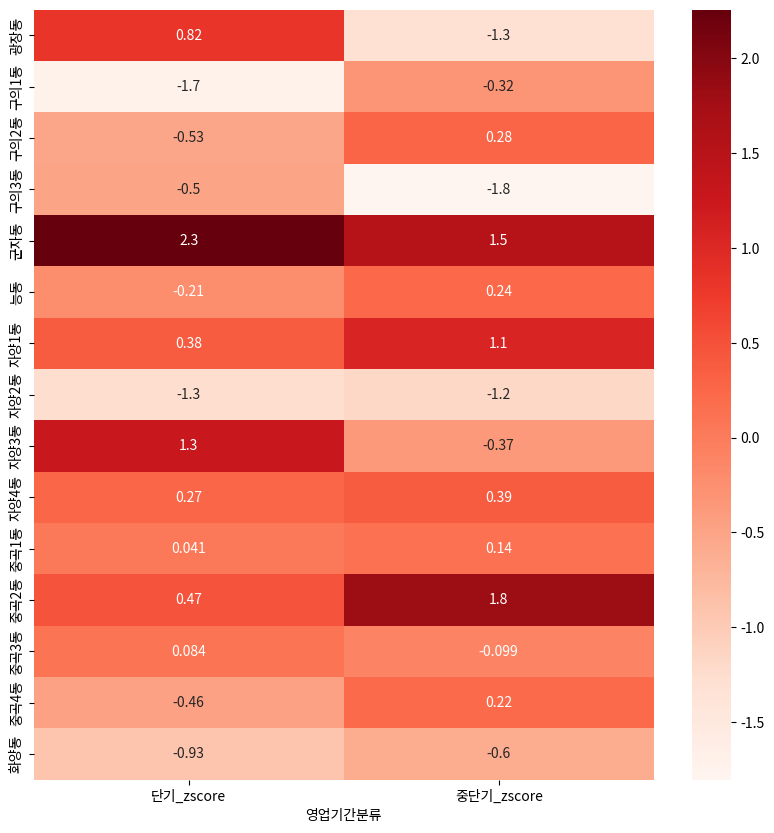

In [337]:
plt.figure(figsize=(10, 10))

sns.heatmap(
    df[['단기_zscore', '중단기_zscore']],
    cmap='Reds',
    annot=True,
    yticklabels=df['행정동']
)

plt.show()

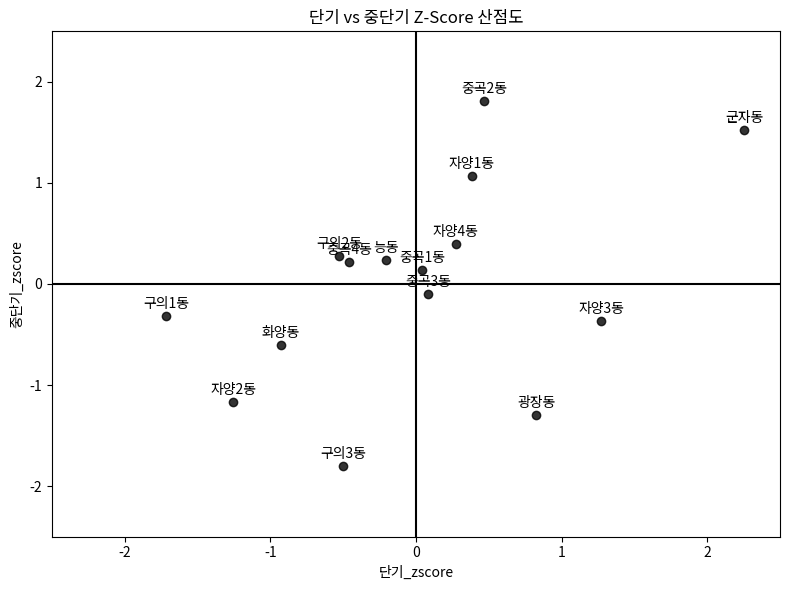

In [366]:
plt.figure(figsize=(8, 6))
plt.scatter(df['단기_zscore'], df['중단기_zscore'], marker='o', alpha=0.8, color='black')

for _, row in df.iterrows():
    plt.text(
        row['단기_zscore'],      # x축 오프셋
        row['중단기_zscore'] + 0.05,    # y축 오프셋
        row['행정동'],
        fontsize=10,
        va='bottom',                    # 수직 정렬: 중앙
        ha='center'                       # 수평 정렬: 왼쪽
    )

plt.xlabel('단기_zscore')
plt.ylabel('중단기_zscore')
plt.title('단기 vs 중단기 Z-Score 산점도')
plt.axvline(0, color='black')
plt.axhline(0, color='black')
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.tight_layout()
plt.show()